In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [4]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()
center_idx_ctxt = da.queries[-1].get_center_idx()
winsize_ctxt = da.queries[-1].winsize
if center_idx_ctxt < 0:
    center_idx_ctxt = winsize_ctxt + center_idx_ctxt
da.seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


13 cluster
0     1451
1      411
2      406
7      223
3      122
10     118
9       96
5       72
8       70
6       63
12      59
4       47
11      27
Name: count, dtype: int64


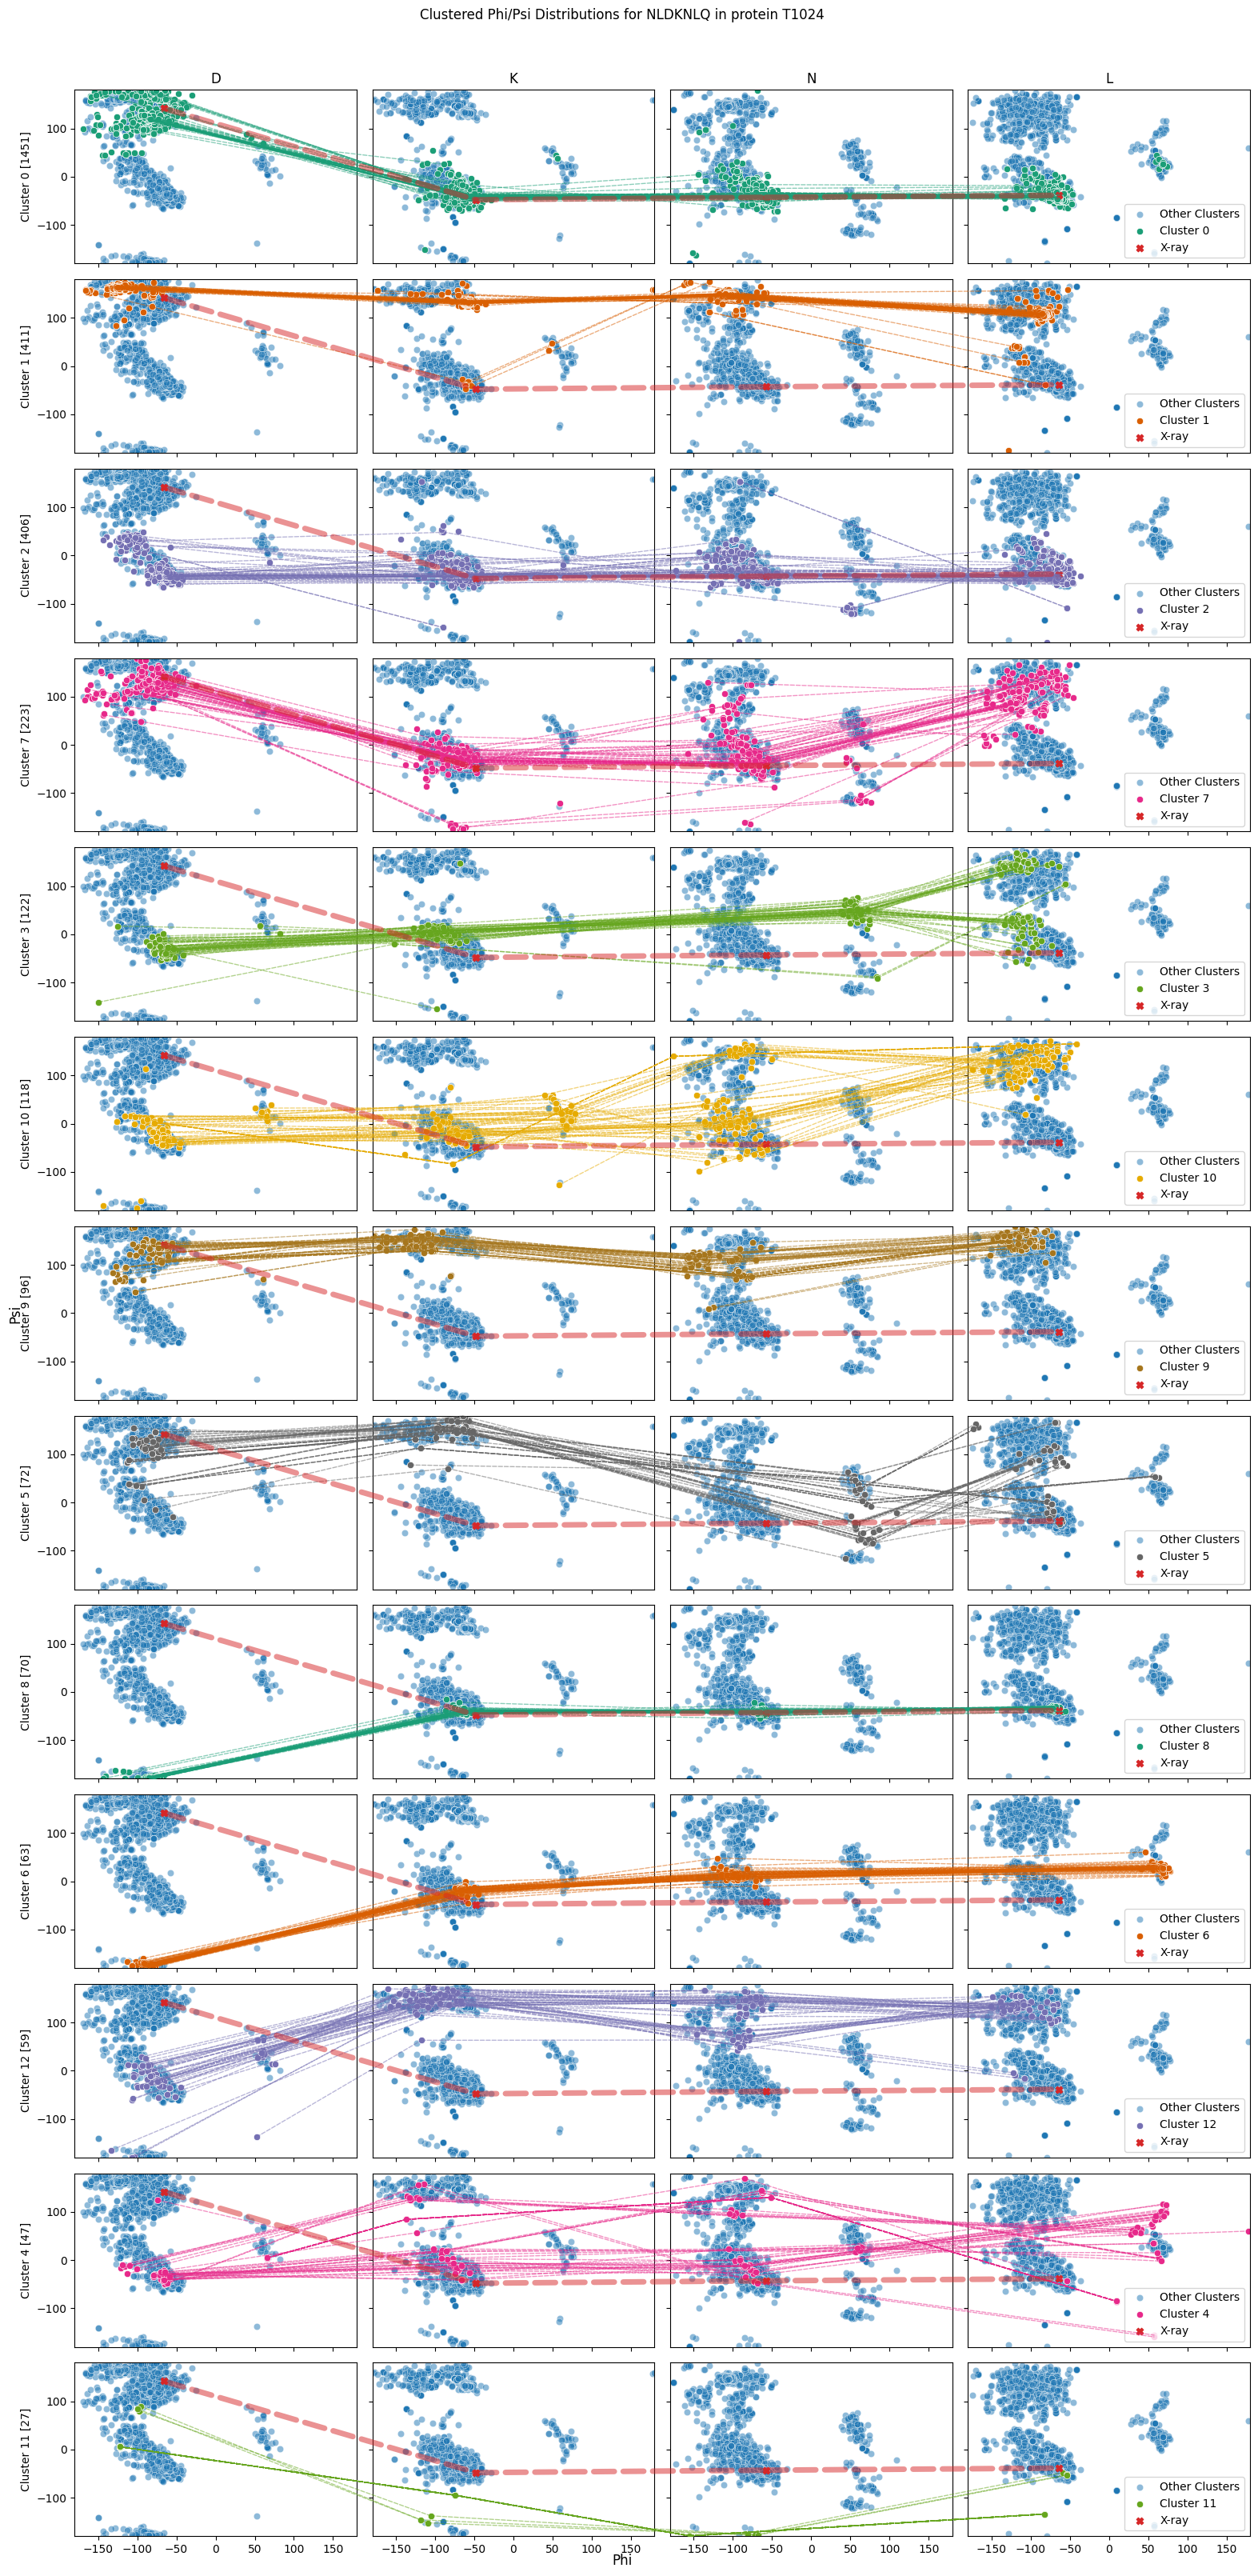

In [56]:
q = da.queries[0]
seq_ctxt = da.seqs_for_window[1]
seq = q.get_subseq(seq_ctxt)
phi_psi_dist = q.results_window[q.results_window.seq == seq]
phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]

max_sil_avg = -1
for k in range(2, min(phi_psi_dist.shape[0], 2**q.winsize)):
    kmeans = KMeans(n_clusters=k).fit(phi_psi_dist.values)
    sil_avg = silhouette_score(phi_psi_dist.values, kmeans.labels_)
    if sil_avg > max_sil_avg:
        max_sil_avg = sil_avg
        phi_psi_dist['cluster'] = kmeans.labels_
        chosen_centroids = kmeans.cluster_centers_
        n_clusters = k
print(n_clusters, phi_psi_dist.cluster.value_counts())
clusters = phi_psi_dist.groupby('cluster').count().sort_values('phi_0', ascending=False).index.values

center_idx = q.get_center_idx()
if center_idx < 0:
    center_idx = q.winsize + center_idx
xray_pos = da.xray_phi_psi[da.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
xrays = da.xray_phi_psi[(da.xray_phi_psi.pos >= xray_pos-center_idx) & (da.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)]

colors = sns.color_palette('Dark2', n_clusters)
fig, axes = plt.subplots(n_clusters, q.winsize, figsize=(16, 32), sharey=True, sharex=True)
for i,axrow in enumerate(axes):
    for j, ax in enumerate(axrow):
        cluster_dist = phi_psi_dist[phi_psi_dist.cluster == clusters[i]]

        sns.scatterplot(data=phi_psi_dist[phi_psi_dist.cluster != clusters[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
        sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters[i]}', color=colors[i])
        ax.scatter(xrays.phi.iloc[j], xrays.psi.iloc[j], color='tab:red', marker='X', label='X-ray', zorder=1000)
        
        def add_conn(xyA, xyB, color, lw, **kwargs):
            con = ConnectionPatch(
                xyA=xyA, 
                xyB=xyB, 
                coordsA="data", coordsB="data", 
                axesA=axrow[j], axesB=axrow[j+1], 
                color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
            )
            fig.add_artist(con)
        if j < q.winsize - 1:
            for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
            add_conn((xrays.phi.iloc[j], xrays.psi.iloc[j]), (xrays.phi.iloc[j+1], xrays.psi.iloc[j+1]), 'tab:red', 5, zorder=100)

        ax.set_xlim(-180, 180)
        ax.set_ylim(-180, 180)
        ax.set_xlabel('')
        if j == q.winsize - 1:
            ax.legend()
        else:
            ax.legend().remove()
        if i == 0:
            ax.set_title(xrays.iloc[j].res)
        if j == 0:
            ax.set_ylabel(f'Cluster {clusters[i]} [{cluster_dist.shape[0]}]')
fig.supxlabel('Phi')
fig.supylabel('Psi')
fig.suptitle(f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}', y=1.01)
plt.tight_layout()